In [1]:
import os
import shutil
from monai.utils import first, set_determinism, progress_bar
import SimpleITK as sitk  # noqa: N813
import numpy as np
import itk
import tempfile
import monai
from monai.data import PILReader
from monai.transforms import (LoadImage, LoadImaged,ScaleIntensityRangePercentiles, Resized, Compose, SaveImage, 
ScaleIntensity,RandScaleIntensity, SpatialPadd)
from monai.config import print_config
from monai.data import CacheDataset, NiftiSaver
import glob
import torch
import nibabel as nib
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    RandAffined,
    SpatialPadd,
    Rand3DElasticd,
    RandFlipd,
    ResizeWithPadOrCropd
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch, PatchDataset
from monai.config import print_config
from monai.apps import download_and_extract
import matplotlib.pyplot as plt

In [2]:
#hyperparameters
batch_size = 2 #image data gen to read array generator from c3d*

patch_radius= np.array([15,15,15]) #in voxels -- patch will be shape: 1+2*radius

#3D rotation augmentation; only for training set
num_augment = 2 #number of augmentations per patch
angle_stdev = 30 #stdev of normal distribution for sampling angle (in degrees)

#sampling radius
radius = patch_radius 

num_channels = 2 #ct and contacts


#creating sampling radius argument (R0xR1xR2)
radius_arg = 'x'.join([str(rad) for rad in radius])

#patch shape = 1+2*radius
dims = 1+2*radius

In [3]:
cd

/home/athurai3


In [4]:
fname = 'projects/ctb-akhanf/athurai3/unet_contact_seg/sample_data/sub-P001/sub-P001_desc-znorm_patches.dat'
bps = 4 * num_channels * np.prod(dims)         # Bytes per sample
file_size = os.path.getsize(fname) 
num_samples = np.floor_divide(file_size,bps)   # Number of samples
print(file_size)
print(bps)
print(num_samples)


#can change first index from num_samples to try with training on smaller number of jobs, kjupyter job
dims = dims.astype('int')
arr_shape_train = (num_samples, dims[0],dims[1],dims[2],num_channels)

arr_train = np.memmap(fname,'float32','r',shape=arr_shape_train)
#arr_train = np.swapaxes(arr_train,1,3)
print(arr_shape_train)

266689032
238328
1119
(1119, 31, 31, 31, 2)


In [5]:
fname_val = 'projects/ctb-akhanf/athurai3/unet_contact_seg/sample_data/sub-P002/sub-P002_desc-znorm_patches.dat'

bps = 4 * num_channels * np.prod(dims)         # Bytes per sample
file_size_val = os.path.getsize(fname_val) 
num_samples_val = np.floor_divide(file_size_val,bps)   # Number of samples
print(file_size_val)
print(bps)
print(num_samples_val)


#can change first index with num_samples_val to try with training on smaller number of jobs, kjupyter job
dims = dims.astype('int')
arr_shape_val = (num_samples_val,dims[0],dims[1],dims[2],num_channels)

arr_val = np.memmap(fname_val,'float32','r',shape=arr_shape_val)
#arr_val = np.swapaxes(arr_val,1,3)
print(arr_shape_val)


75788304
238328
318
(318, 31, 31, 31, 2)


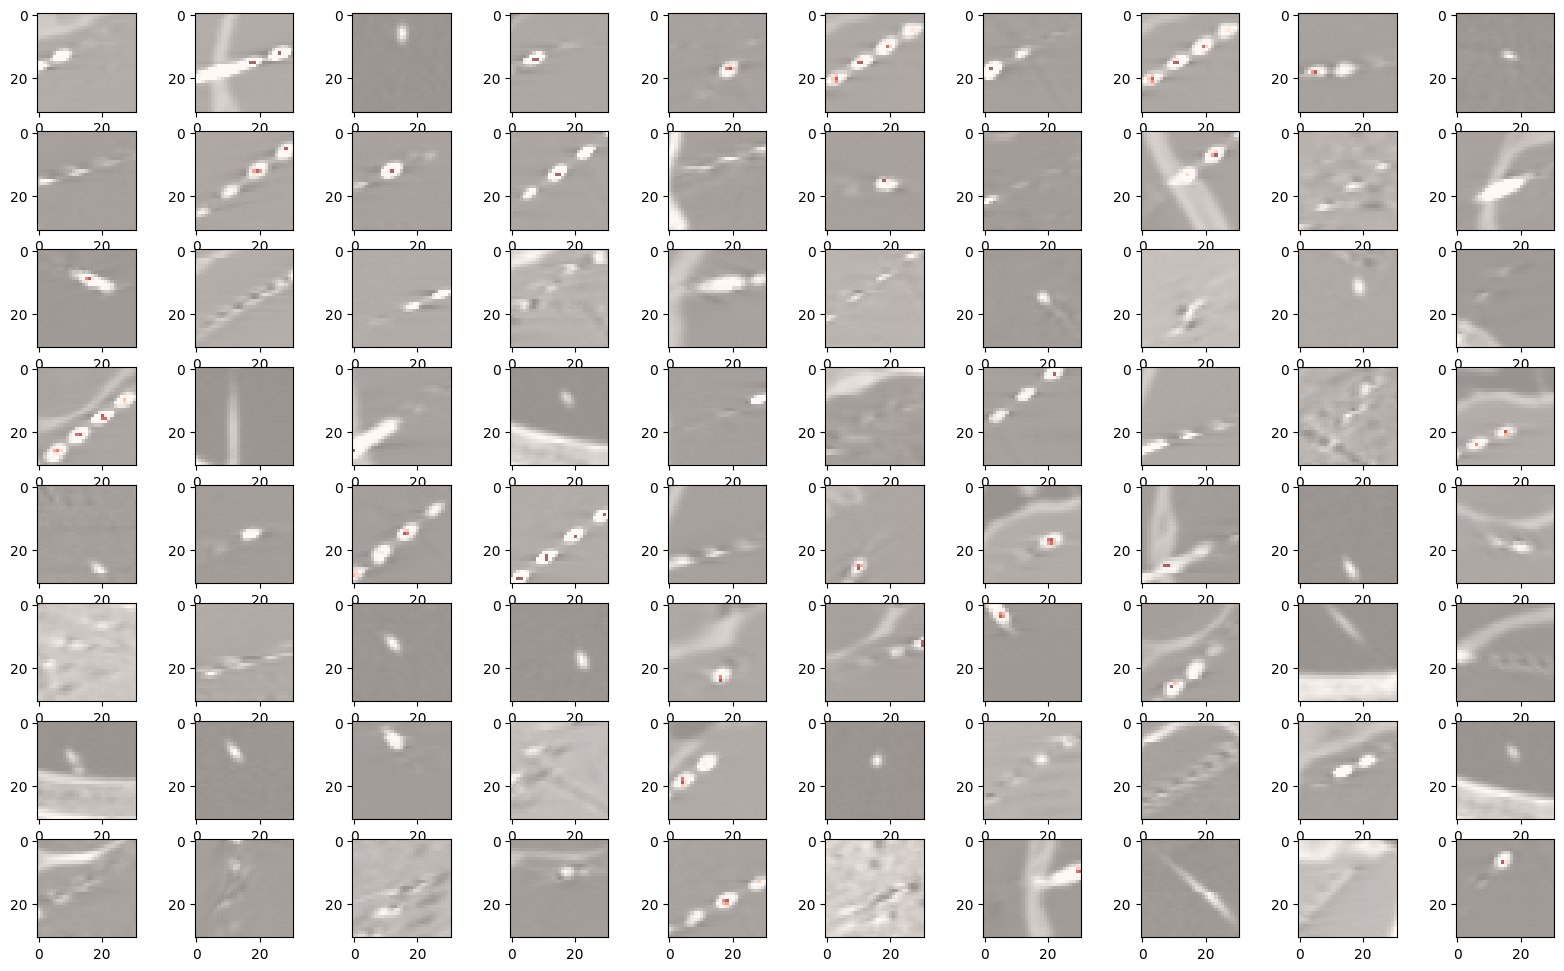

In [6]:
import matplotlib.pyplot as plt
from numpy.random import randint

plt.figure(figsize=(20,12))
nrows=8
ncols=10
for i,randi in enumerate(randint(low=0,high=arr_train.shape[0],size=(nrows*ncols,))):
  plt.subplot(nrows,ncols,i+1)
  plt.imshow(np.squeeze(arr_train[randi,:,15,:,0]),cmap='gray')
  plt.imshow(np.squeeze(arr_train[randi,:,15,:,1]),alpha=0.6,cmap="Reds")

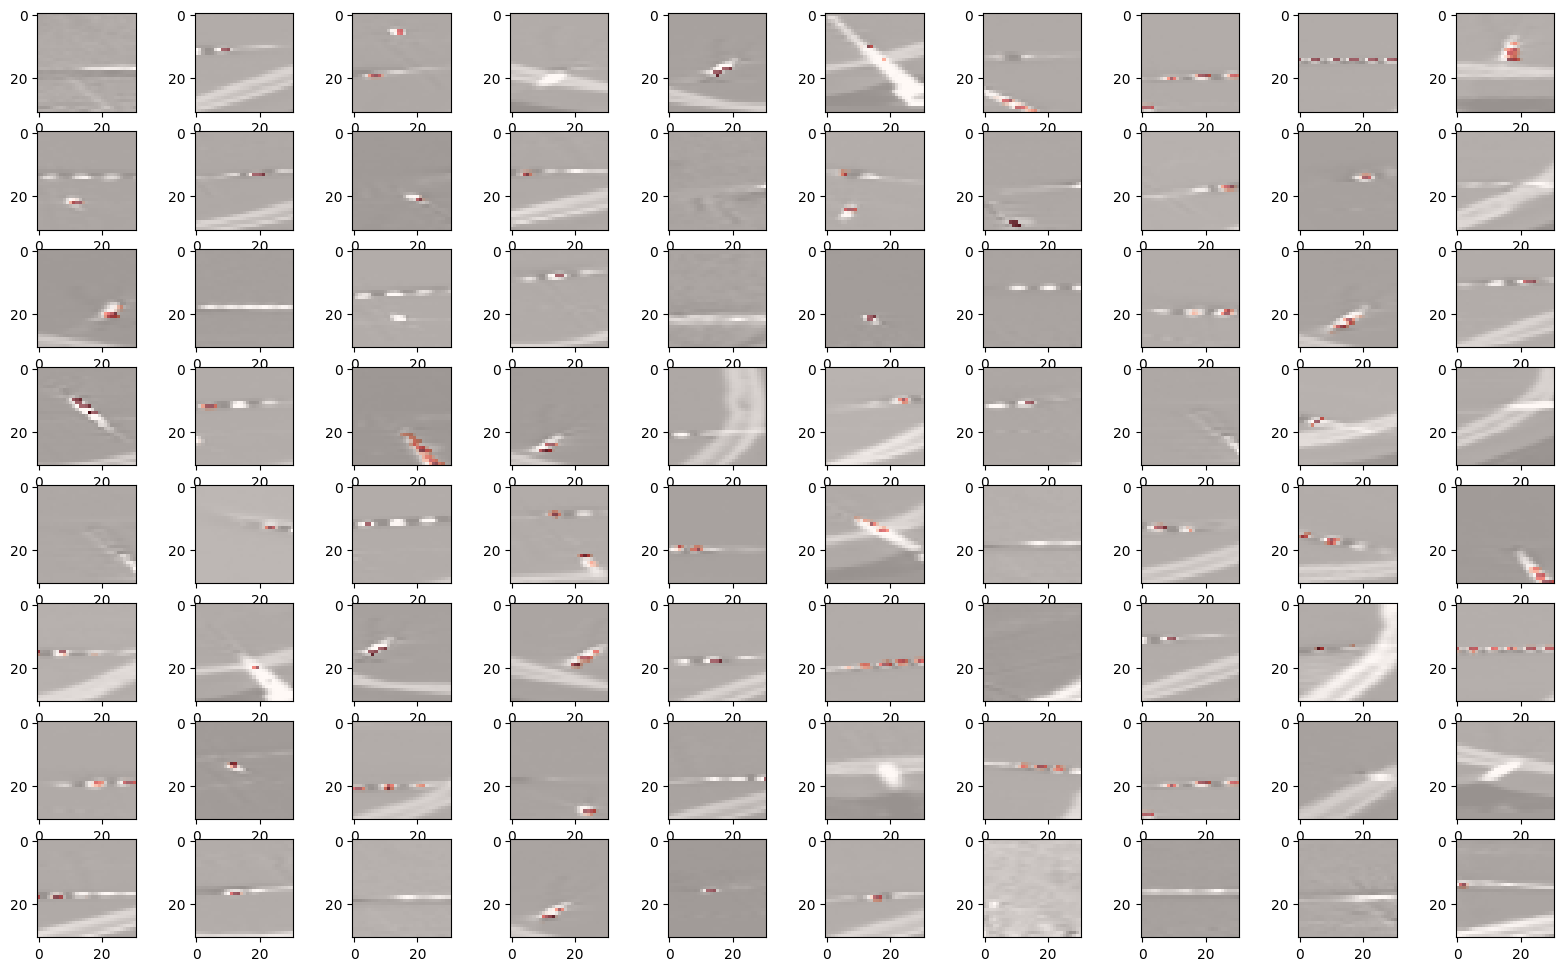

In [7]:
plt.figure(figsize=(20,12))
nrows=8
ncols=10
for i,randi in enumerate(randint(low=0,high=arr_val.shape[0],size=(nrows*ncols,))):
  plt.subplot(nrows,ncols,i+1)
  plt.imshow(np.squeeze(arr_val[randi,:,15,:,0]),cmap='gray')
  plt.imshow(np.squeeze(arr_val[randi,:,15,:,1]),alpha=0.6,cmap="Reds")

In [8]:
#arr_train = np.swapaxes(arr_train,1,3)
#arr_val = np.swapaxes(arr_val,1,3)

arr_train = np.swapaxes(arr_train,1,4) #swap second axis with last -  that of channels (image/label)
arr_val = np.swapaxes(arr_val, 1, 4) #swap second axis with last - that of channels (image/label)

In [9]:
arr_train_image = arr_train[:,0,:,:,:].reshape(arr_train.shape[0],1,arr_train.shape[2],arr_train.shape[3],arr_train.shape[4])
arr_train_label = arr_train[:,1,:,:,:].reshape(arr_train.shape[0],1,arr_train.shape[2],arr_train.shape[3],arr_train.shape[4])

arr_val_image = arr_val[:,0,:,:,:].reshape(arr_val.shape[0],1, arr_val.shape[2],arr_val.shape[3],arr_val.shape[4])
arr_val_label = arr_val[:,1,:,:,:].reshape(arr_val.shape[0],1, arr_val.shape[2],arr_val.shape[3],arr_val.shape[4])

In [10]:
np.unique(arr_train_label[:][:])

array([0.0000000e+00, 1.0658141e-13, 2.2998847e-10, ..., 9.9993134e-01,
       9.9993896e-01, 1.0000000e+00], dtype=float32)

In [11]:
np.unique(arr_val_label[:][:])

array([0.0000000e+00, 4.2632564e-13, 6.3948846e-13, ..., 9.9997962e-01,
       9.9998474e-01, 1.0000000e+00], dtype=float32)

In [12]:
thresh_train_label = np.where(arr_train_label[:][:] > 0, 1, arr_train_label)
thresh_val_label = np.where(arr_val_label[:][:] > 0, 1, arr_val_label)

In [13]:
thresh_train_label.shape

(1119, 1, 31, 31, 31)

In [14]:
np.unique(thresh_val_label[:][:])

array([0., 1.], dtype=float32)

In [15]:
np.unique(thresh_train_label[:][:])

array([0., 1.], dtype=float32)

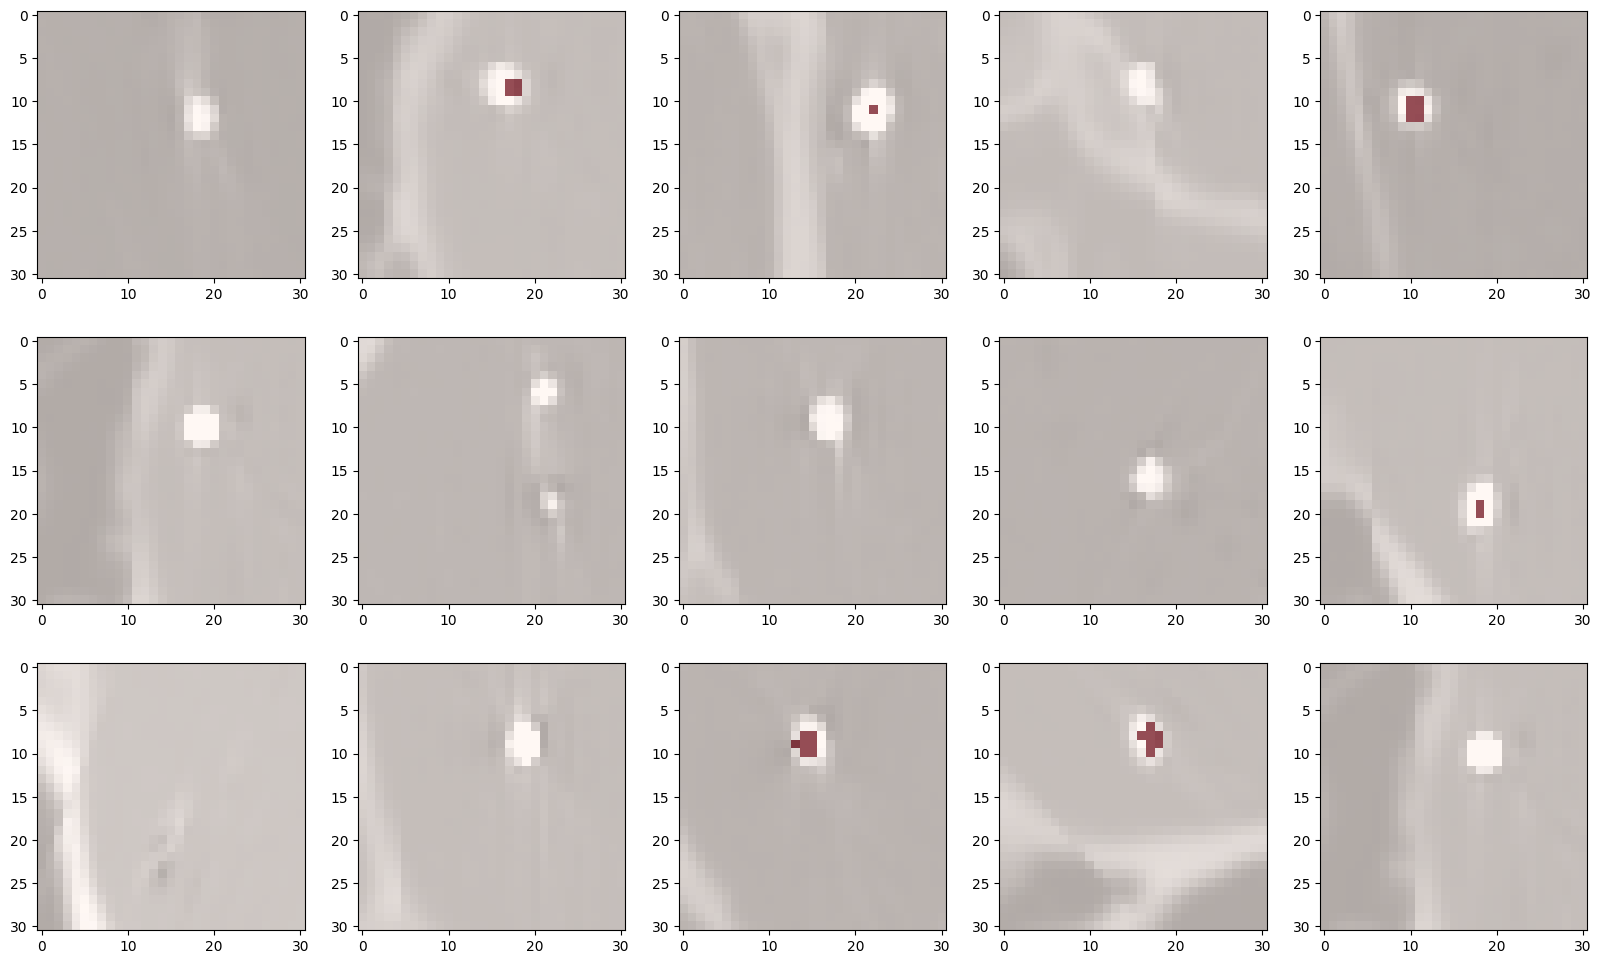

In [16]:
plt.figure(figsize=(20,12))
nrows=3
ncols=5
for i,randi in enumerate(randint(low=0,high=arr_val.shape[0],size=(nrows*ncols,))):
  plt.subplot(nrows,ncols,i+1)
  plt.imshow(np.squeeze(arr_train_image[randi,0,:,15,:]),cmap='gray')
  #plt.imshow(np.squeeze(arr_train_label[randi,0,:,:,30]),cmap="gray")
  plt.imshow(np.squeeze(thresh_train_label[randi,0,:,15,:]),alpha=0.7,cmap="Reds")

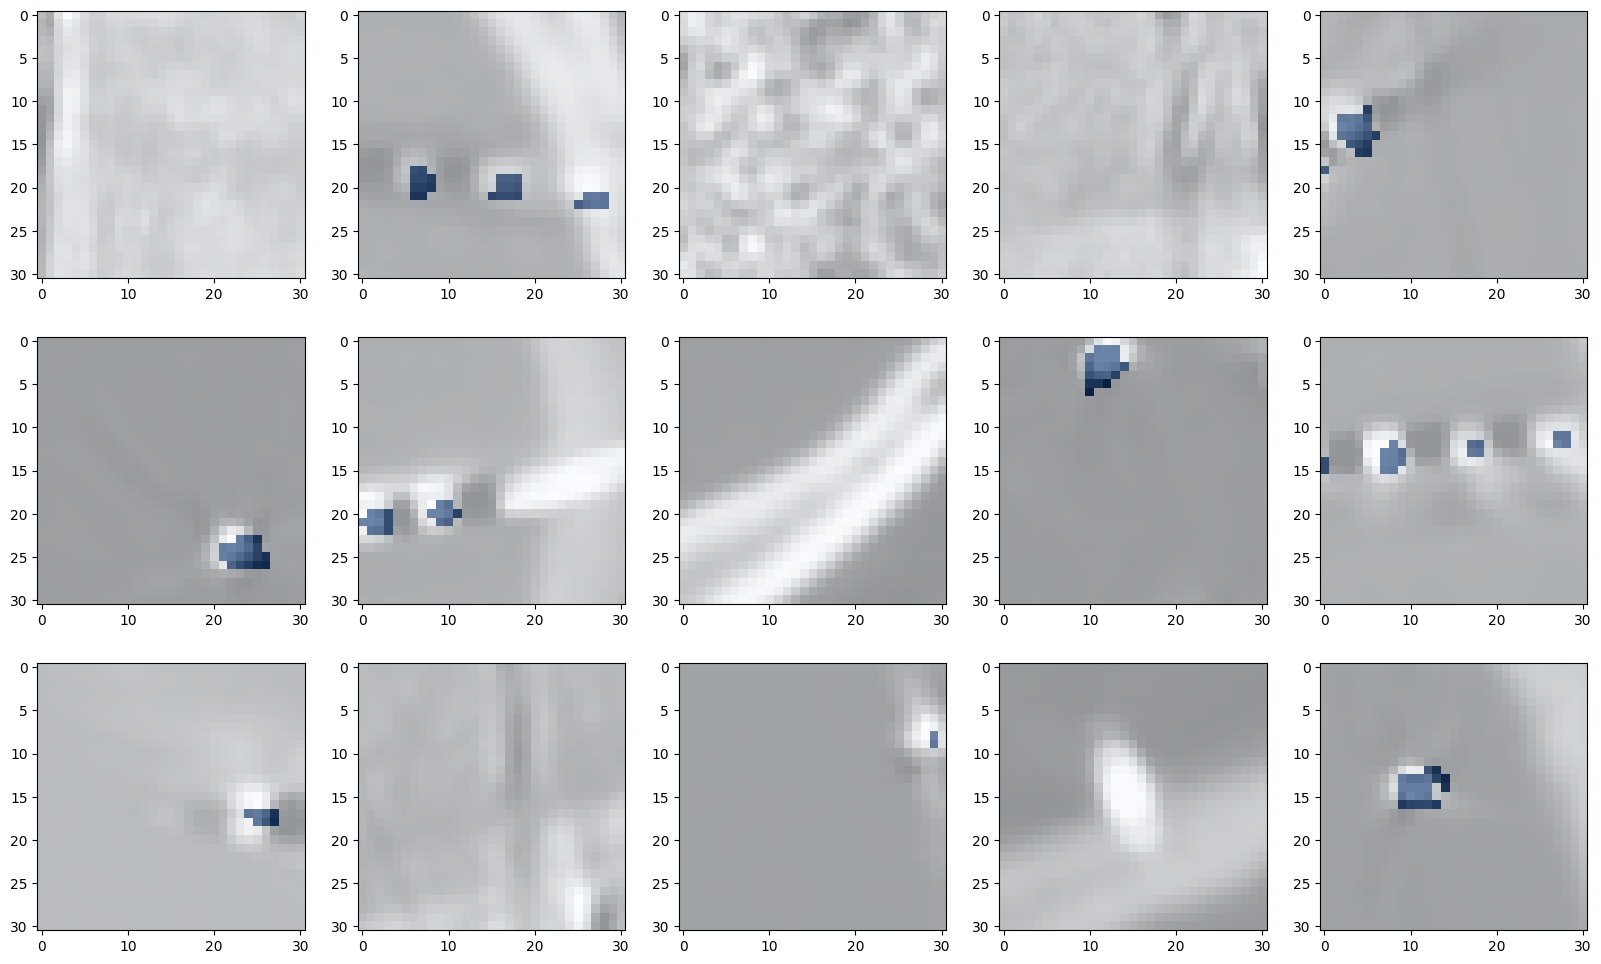

In [17]:
plt.figure(figsize=(20,12))
nrows=3
ncols=5
for i,randi in enumerate(randint(low=0,high=arr_val.shape[0],size=(nrows*ncols,))):
  plt.subplot(nrows,ncols,i+1)
  plt.imshow(np.squeeze(arr_val_image[randi,0,:,:,15]),cmap='gray')
  #plt.imshow(np.squeeze(arr_val_label[randi,0,:,:,30]),alpha=0.6,cmap="Reds")
  plt.imshow(np.squeeze(thresh_val_label[randi,0,:,:,15]),alpha=0.6,cmap="Blues")

In [18]:
arr_train_dict= [{"image": ct, "label": contact} for ct, contact in zip(arr_train_image,thresh_train_label)]
arr_val_dict= [{"image": ct, "label": contact} for ct, contact in zip(arr_val_image,thresh_val_label)]

In [19]:
arr_train_dict_org = [{"image": ct, "label": contact} for ct, contact in zip(arr_train_image,arr_train_label)]
arr_val_dict_org = [{"image": ct, "label": contact} for ct, contact in zip(arr_val_image,arr_val_label)]

In [20]:
from monai.transforms import EnsureTyped

train_transforms = Compose(
    [
                
        SpatialPadd(
            keys = ("image", "label"),
            spatial_size=(31,31,31)
        ),
        EnsureTyped (keys= ("image", "label"))
    ]
)

val_transforms = Compose(
    [
        SpatialPadd(
            keys = ("image", "label"),
            spatial_size=(31,31,31)
        ),
        EnsureTyped (keys= ("image", "label"))
    ]
)

train_patches_dataset = CacheDataset(data=arr_train_dict ,transform = train_transforms, cache_rate =0.75, copy_cache=False, progress=True) # dataset with cache mechanism that can load data and cache deterministic transforms’ result during training.
validate_patches_dataset = CacheDataset(data=arr_val_dict, transform = val_transforms, cache_rate = 0.75, copy_cache=False,progress=True)

Loading dataset: 100%|██████████| 238/238 [00:00<00:00, 906.97it/s]


In [21]:

train_patches_dataset = CacheDataset(data=arr_train_dict ,transform = train_transforms, cache_rate =0.75, copy_cache=False, progress=True) # dataset with cache mechanism that can load data and cache deterministic transforms’ result during training.
validate_patches_dataset = CacheDataset(data=arr_val_dict, transform = val_transforms, cache_rate = 0.75, copy_cache=False,progress=True)

Loading dataset: 100%|██████████| 238/238 [00:00<00:00, 1102.50it/s]


In [22]:
batch_size = 32
training_steps = int(num_samples / batch_size) # number of training steps per epoch
validation_steps = int(num_samples_val/ batch_size) # number of validation steps per epoch
print(training_steps)
print(validation_steps)

34
9


In [23]:
train_loader = DataLoader(train_patches_dataset, batch_size=batch_size, shuffle=False, num_workers=1) #num_workers is number of cpus we request
val_loader = DataLoader(validate_patches_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

In [27]:
for i, batch_data in enumerate(train_loader):
    print(batch_data['image'].shape)
    image, label = (batch_data["image"][0][0], batch_data["label"][0][0])
    print(f"image shape: {image.shape}, label shape: {label.shape}")
    plt.figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image[:, 15, :], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("label")
    plt.imshow(label[:, 15, :])
    plt.show()

torch.Size([32, 1, 31, 31, 31])


TypeError: unhashable type: 'slice'

In [ ]:
for batch_data in val_loader:
    print(batch_data['image'].shape)
    image, label = (batch_data["image"][0][0], batch_data["label"][0][0])
    print(f"image shape: {image.shape}, label shape: {label.shape}")
    print(f"image shape: {image.shape}, label shape: {label.shape}")
    plt.figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image[:, 15, :], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("label")
    plt.imshow(label[:, 15, :])
    plt.show()

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    dropout = 0.4,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceCELoss(sigmoid = True, include_background=False)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [16]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [ ]:
import time
#from pytorchtools import EarlyStopping

date = '2024Jan31'
patience = 100# epochs it will take for training to terminate if no improvement
#early_stopping = EarlyStopping(patience=patience, verbose=True, path = f'/home/athurai3/scratch/seeg_contacts_loc/derivatives/UNET/{date}_diceloss_checkpoint.pt')
start = time.time() # initializing variable to calculate training time

max_epochs = 5
epoch_loss_values = [0]
metric_values = [0]
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    #progress_bar(
        #index = epoch+1, 
        #count=max_epochs, 
        #desc = f"epoch {epoch+1}, training loss: {epoch_loss_values[-1]:.4f}, validation metric: {metric_values[-1]:.4f}",
        #newline = True)
    step = 0
    for batch_data in train_loader:
        step +=1
        images = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f'Train Loss: {loss.item():.4f}')

    avg_training_loss = epoch_loss / training_steps
    
    epoch_loss_values.append(avg_training_loss)
    
    model.eval()
    
    with torch.no_grad():
        for i, val_data in enumerate(val_loader):
            val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
            val_outputs = model(val_images)
            val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
            val_labels = [post_label(i) for i in decollate_batch(val_labels)]
            val_loss = dice_metric(val_outputs, val_labels)
            
        # aggregate the final mean dice result
        metric = dice_metric.aggregate().item()
        # reset the status for next validation round
        dice_metric.reset()
        s
        metric_values.append(metric)

        early_stopping(metric, model) # early stopping is based on the average validation mse for an epoch, keeps track of last best model
        
    if early_stopping.early_stop:
        print("Early stopping") # stops early if validation mae has not improved for 100 epochs
        break
    

end = time.time()
time = end - start
print(time)

----------
epoch 1/1


single channel prediction, `softmax=True` ignored.
single channel prediction, `to_onehot_y=True` ignored.


In [ ]:
with open (f'/home/athurai3/scratch/seeg_contacts_loc/derivatives/UNET/{date}_dicelossmodel_stats.txt', 'w') as file:  
    file.write(f'training time: {time}\n')  
    file.write(f'training loss: {epoch_loss_values[:]} validation loss: {early_stopping.val_loss_min}')

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(list(range(len(epoch_loss_values))), epoch_loss_values, label="Training Loss")
plt.plot(list(range(len(metric_values))), metric_values , label="Validation Loss")
plt.grid(True, "both", "both")
plt.legend()
plt.savefig(f'/home/athurai3/scratch/seeg_contacts_loc/derivatives/UNET/{date}_dicelossfunction.png')